In [83]:
#librerie necessarie per la classificazione
%matplotlib inline
import math
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import metrics
from collections import defaultdict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score


In [84]:
import itertools    
def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Oranges):
        import itertools
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [85]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [86]:
#open file
df = pd.read_csv('abalone-data.csv')

In [87]:
#rename columns
df.columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']

In [88]:
#discard the “Infant” abalones
df = df[df['Sex'] != 'I' ]

In [89]:
# Generate a mapping of Sex from a string to a number representation    
sexes = sorted(df['Sex'].unique()) #Return unique values 
genders_mapping = dict(zip(sexes, range(0, len(sexes) + 1))) #create a dictionary {F: number of records; M: number of records}
# Transform Sex from a string to a number representation
df['Sex'] = df['Sex'].map(genders_mapping).astype(int) #Male=1; Female=0

In [90]:
#copia df per dati sbilanciati
df_imb = df.copy()

In [91]:
#copia df per dati oversampled
df_os = df.copy()

In [92]:
#classi bilanciate
df['Bin'] = pd.cut(df['Rings'], bins=[0, 10, 29], right=True, labels = [0, 1] )

In [93]:
#classi sbilanciate
df_imb['Bin'] = pd.cut(df_imb['Rings'], bins=[0, 14, 29], right=True, labels = [0, 1] ) 
print(df_imb.Bin.value_counts(sort=True)*100/len(df_imb)) 
df_imb = df_imb.drop(['Rings'], axis=1)

0    88.359788
1    11.640212
Name: Bin, dtype: float64


In [94]:
#classi oversampled
df_os['Bin'] = pd.cut(df_os['Rings'], bins=[0, 14, 29], right=True, labels = [0, 1] ) 
print(df_os.Bin.value_counts(sort=True)*100/len(df_os)) 
df_os = df_os.drop(['Rings'], axis=1)

0    88.359788
1    11.640212
Name: Bin, dtype: float64


In [95]:
df = df.drop(labels= ['Rings'], axis = 1)

In [96]:
train_data = df.values
train_features = train_data[:, 0:7]

In [97]:
train_target = train_data[:,8].astype('int')

In [98]:
x_train, x_test, y_train, y_test = train_test_split(train_features, train_target, test_size = 0.20, random_state = 0)

# BAGGING - CLASSI BILANCIATE

In [109]:
#stima del classificatore ad albero
clf = DecisionTreeClassifier()

parameters = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'], 
              'min_samples_split': [2,3,4,5], 
              'min_samples_leaf': [2,3,4,5],
             }
scorer = make_scorer(accuracy_score)

In [110]:
grid_search = GridSearchCV(clf, param_grid = parameters, scoring=scorer)

In [111]:
grid_fit = grid_search.fit(x_train,y_train)

In [112]:
print ('I migliori parametri dopo la Grid Search sono:', grid_fit.best_params_)

('I migliori parametri dopo la Grid Search sono:', {'min_samples_split': 3, 'splitter': 'random', 'criterion': 'gini', 'min_samples_leaf': 5})


In [113]:
clf.set_params(criterion='gini', splitter='random', max_depth=None, 
                                  min_samples_split=3, min_samples_leaf=5)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')

In [114]:
clf = clf.fit(x_train, y_train);

In [115]:
predictions = clf.predict_proba(x_test)

In [116]:
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier(base_estimator=clf)
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

param = {'max_samples': [1.0, 0.8, 0.6, 0.4, 0.2, 0.1],
         'n_estimators': range(10, 100, 10)
        }

In [117]:
grid_bag = GridSearchCV(bag, param_grid = param, scoring=scoring, refit='AUC')

In [118]:
grid_bag = grid_bag.fit(x_train,y_train)

In [119]:
print ('I migliori parametri dopo la Grid Search sono:', grid_bag.best_params_)

('I migliori parametri dopo la Grid Search sono:', {'n_estimators': 70, 'max_samples': 1.0})


In [120]:
bag.set_params(max_samples=1.0, n_estimators=70)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=70, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [121]:
bag = bag.fit(x_train, y_train);

In [122]:
test_pred = bag.predict_proba(x_test)

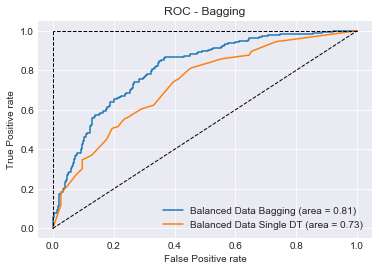

In [123]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

fpr_test, tpr_test, _= roc_curve(y_test, test_pred[:,1])
roc_auc = auc(fpr_test, tpr_test)

fpr_clf, tpr_clf, _ =  roc_curve(y_test, predictions[:,1])
roc_auc_clf= auc(fpr_clf, tpr_clf)

sns.set_style("darkgrid")
plt.plot(fpr_test,tpr_test, label='Balanced Data Bagging (area = %0.2f)' % roc_auc)
plt.plot(fpr_clf,tpr_clf, label='Balanced Data Single DT (area = %0.2f)' % roc_auc_clf)

plt.title("ROC - Bagging")

plt.legend(loc="lower right")
plt.plot([0,1], [0,1], 'k--', lw = 1)
plt.plot([0,0], [1,0], 'k--', lw = 1, color = 'black')
plt.plot([1,0], [1,1], 'k--', lw = 1, color = 'black')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate');
plt.show()

# BAGGING - CLASSI SBILANCIATE

In [125]:
train_data_imb = df_imb.values
train_features_imb = train_data_imb[:, 0:7]

In [126]:
train_target_imb = train_data_imb[:,8].astype('int')

In [127]:
x_train_imb, x_test_imb, y_train_imb, y_test_imb = train_test_split(train_features_imb, train_target_imb, test_size = 0.20, random_state = 0)

In [128]:
#stima del classificatore ad albero
clf_imb = DecisionTreeClassifier()

parameters_imb = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'], 
              'min_samples_split': [2,3,4,5], 
              'min_samples_leaf': [2,3,4,5],
             }
scorer = make_scorer(accuracy_score)

In [129]:
grid_search_imb = GridSearchCV(clf_imb, param_grid = parameters_imb, scoring=scorer)

In [130]:
grid_fit_imb = grid_search_imb.fit(x_train_imb,y_train_imb)

In [131]:
print ('I migliori parametri dopo la Grid Search sono:', grid_fit_imb.best_params_)

('I migliori parametri dopo la Grid Search sono:', {'min_samples_split': 4, 'splitter': 'random', 'criterion': 'entropy', 'min_samples_leaf': 5})


In [132]:
clf_imb.set_params(splitter='random', min_samples_leaf=5, criterion='entropy', min_samples_split= 4)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')

In [133]:
clf_imb = clf_imb.fit(x_train_imb, y_train_imb);

In [134]:
predictions_imb = clf_imb.predict_proba(x_test_imb)

In [143]:
bag_imb = BaggingClassifier(base_estimator=clf_imb)
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

param = {'max_samples': [1.0, 0.8, 0.6, 0.4, 0.2, 0.1],
         'n_estimators': range(10, 100, 10)
        }

In [144]:
grid_bag_imb = GridSearchCV(bag_imb, param_grid = param, scoring=scoring, cv=5, refit='AUC')

In [145]:
grid_bag_imb = grid_bag_imb.fit(x_train_imb,y_train_imb)

In [146]:
print ('I migliori parametri dopo la Grid Search sono:', grid_bag_imb.best_params_)

('I migliori parametri dopo la Grid Search sono:', {'n_estimators': 60, 'max_samples': 1.0})


In [147]:
bag_imb.set_params(max_samples=0.1, n_estimators=60)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.1, n_estimators=60, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [148]:
bag_imb = bag_imb.fit(x_train_imb, y_train_imb);

In [149]:
test_pred_imb = bag_imb.predict_proba(x_test_imb)

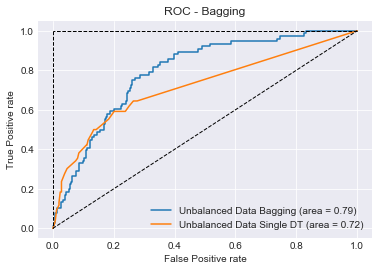

In [150]:
fpr_test_imb, tpr_test_imb, _= roc_curve(y_test_imb, test_pred_imb[:,1])
roc_auc_imb = auc(fpr_test_imb, tpr_test_imb)

fpr_clf_imb, tpr_clf_imb, _ =  roc_curve(y_test_imb, predictions_imb[:,1])
roc_auc_clf_imb= auc(fpr_clf_imb, tpr_clf_imb)

sns.set_style("darkgrid")
plt.plot(fpr_test_imb,tpr_test_imb, label='Unbalanced Data Bagging (area = %0.2f)' % roc_auc_imb)
plt.plot(fpr_clf_imb,tpr_clf_imb, label='Unbalanced Data Single DT (area = %0.2f)' % roc_auc_clf_imb)

plt.title("ROC - Bagging")

plt.legend(loc="lower right")
plt.plot([0,1], [0,1], 'k--', lw = 1)
plt.plot([0,0], [1,0], 'k--', lw = 1, color = 'black')
plt.plot([1,0], [1,1], 'k--', lw = 1, color = 'black')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate');
plt.show()

# BAGGING- OVERSAMPLED

In [151]:
train_data_os = df_os.values
train_features_os = train_data_os[:, 0:7]

In [152]:
train_target_os = train_data_os[:,8].astype('int')

In [156]:
#OVERSAMPLING SULLA CLASSE DI MINORANZA (15-29)
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

In [157]:
sm = SMOTE(ratio = {1:1800})
trainfSMO, traintSMO = sm.fit_sample(train_features_os, train_target_os)

In [179]:
x_train_os, x_test_os, y_train_os, y_test_os = train_test_split(trainfSMO, traintSMO, test_size = 0.20, random_state = 0)

In [180]:
#stima del classificatore ad albero
clf_os = DecisionTreeClassifier()

parameters_os = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'], 
              'min_samples_split': [2,3,4,5], 
              'min_samples_leaf': [2,3,4,5],
             }
scorer = make_scorer(accuracy_score)

In [181]:
grid_search_os = GridSearchCV(clf_os, param_grid = parameters_os, scoring=scorer)

In [182]:
grid_fit_imb = grid_search_os.fit(x_train_os,y_train_os)

In [183]:
print ('I migliori parametri dopo la Grid Search sono:', grid_fit_imb.best_params_)

('I migliori parametri dopo la Grid Search sono:', {'min_samples_split': 5, 'splitter': 'best', 'criterion': 'entropy', 'min_samples_leaf': 3})


In [184]:
clf_os.set_params(splitter='best', min_samples_leaf=3 ,criterion='entropy', min_samples_split= 5)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [185]:
clf_os = clf_os.fit(x_train_os, y_train_os);

In [201]:
predictions_os = clf_os.predict_proba(x_test_os)

In [187]:
bag_os = BaggingClassifier(base_estimator=clf_os)
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

param = {'max_samples': [1.0, 0.8, 0.6, 0.4, 0.2, 0.1],
         'n_estimators': range(10, 100, 10)
        }

In [188]:
grid_bag_os = GridSearchCV(bag_os, param_grid = param, scoring=scoring, refit='AUC')

In [189]:
grid_bag_os = grid_bag_os.fit(x_train_os,y_train_os)

In [190]:
print ('I migliori parametri dopo la Grid Search sono:', grid_bag_os.best_params_)

('I migliori parametri dopo la Grid Search sono:', {'n_estimators': 90, 'max_samples': 1.0})


In [191]:
bag_os.set_params(max_samples=0.8, n_estimators=90)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=90, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [192]:
bag_os = bag_os.fit(x_train_os, y_train_os);

In [202]:
test_pred_os = bag_os.predict_proba(x_test_os)

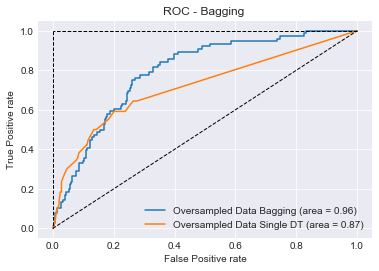

In [206]:
fpr_clf_os, tpr_clf_os, _ =  roc_curve(y_test_os, predictions_os[:,1])
roc_auc_clf_os= auc(fpr_clf_os, tpr_clf_os)

fpr_test_os, tpr_test_os, _= roc_curve(y_test_os, test_pred_os[:,1])
roc_auc_os = auc(fpr_test_os, tpr_test_os)

sns.set_style("darkgrid")
plt.plot(fpr_test_imb,tpr_test_imb, label='Oversampled Data Bagging (area = %0.2f)' % roc_auc_os)
plt.plot(fpr_clf_imb,tpr_clf_imb, label='Oversampled Data Single DT (area = %0.2f)' % roc_auc_clf_os)

plt.title("ROC - Bagging ")

plt.legend(loc="lower right")
plt.plot([0,1], [0,1], 'k--', lw = 1)
plt.plot([0,0], [1,0], 'k--', lw = 1, color = 'black')
plt.plot([1,0], [1,1], 'k--', lw = 1, color = 'black')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate');
plt.show()

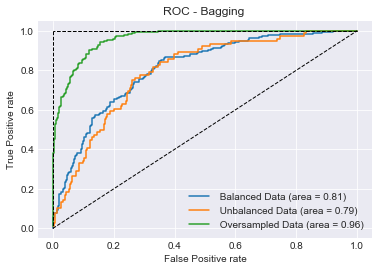

In [205]:
#CURVE A CONFRONTO
fpr_test, tpr_test, _= roc_curve(y_test, test_pred[:,1])
roc_auc = auc(fpr_test, tpr_test)


fpr_tes__imb, tpr_test_imb, _= roc_curve(y_test_imb, test_pred_imb[:,1])
roc_auc_imb = auc(fpr_test_imb, tpr_test_imb)


fpr_tes__os, tpr_test_os, _= roc_curve(y_test_os, test_pred_os[:,1])
roc_auc_os = auc(fpr_test_os, tpr_test_os)



sns.set_style("darkgrid")
plt.plot(fpr_test,tpr_test, label=' Balanced Data (area = %0.2f)' % roc_auc)
plt.plot(fpr_test_imb,tpr_test_imb, label=' Unbalanced Data (area = %0.2f)' % roc_auc_imb)
plt.plot(fpr_test_os,tpr_test_os, label=' Oversampled Data (area = %0.2f)' % roc_auc_os)

plt.title("ROC - Bagging ")

plt.legend(loc="lower right")
plt.plot([0,1], [0,1], 'k--', lw = 1)
plt.plot([0,0], [1,0], 'k--', lw = 1, color = 'black')
plt.plot([1,0], [1,1], 'k--', lw = 1, color = 'black')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate');
plt.show()